In [68]:
%reset -f
%load_ext autoreload
%autoreload 2
    
import matplotlib as mpl
#mpl.use('nbAgg')
mpl.rcParams['figure.figsize'] = (9,7)

from matplotlib import pyplot as plt
#%matplotlib notebook
import ipywidgets


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
from src.beads import *
canvas = Canvas(-20,20,100)

In [70]:
b = Beads(5,3,1,10)
print(b,len(b.components))

<src.beads.Beads object at 0x7fa17b79f908> 10


In [71]:
print(len(b.components))

10


<src.beads.Beads object at 0x7fa181188860> 5


<IPython.core.display.Javascript object>


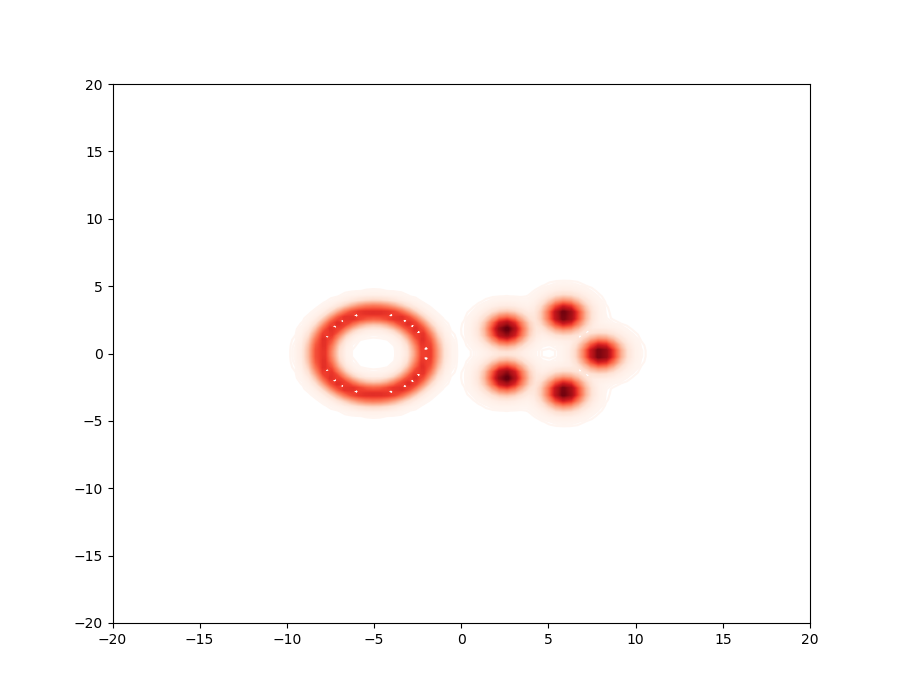

In [79]:
a = Donut(-5,3,1)
b = Beads(5,3,1,5)
print(b,len(b.components))
canvas.clear()
canvas+=a
canvas+=b

fig, ax = plt.subplots(1,1)
canvas.plot(ax, nlines = 500)

In [91]:
bs = [10, 4, 2]
sigmas = [4,1,0.1]
cs = [15, 15, 15]
colors = ['Greens', 'Blues', 'Reds']

sources = [Beads(0,b,sigma,c) for (b,sigma,c) in zip(bs,sigmas,cs)]

In [92]:
print(len(b.components))

5


<IPython.core.display.Javascript object>


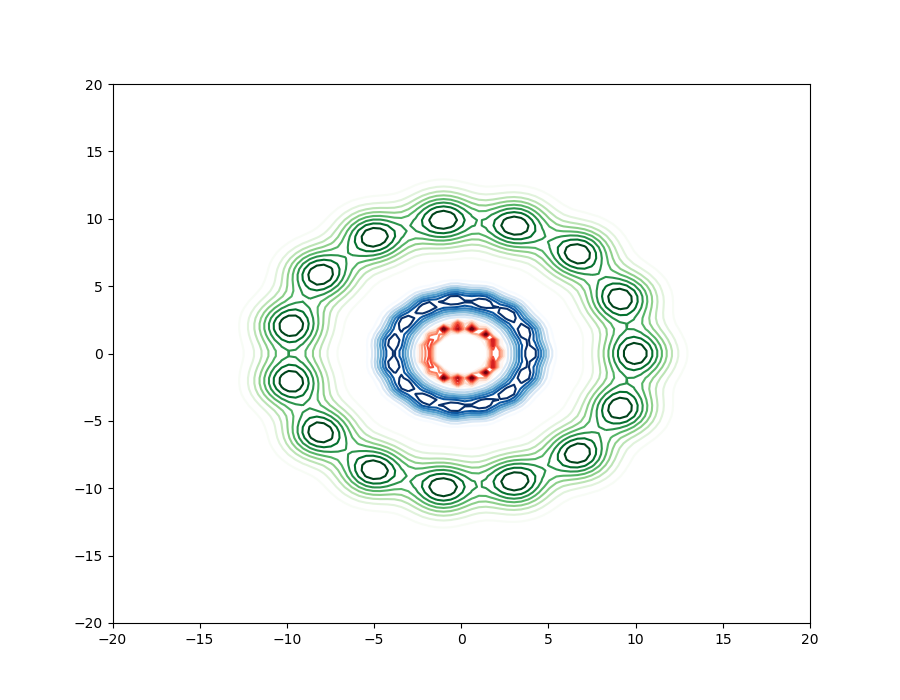

<src.beads.Beads object at 0x7fa17b1e8400> 15 Greens
<src.beads.Beads object at 0x7fa17b6c4da0> 15 Blues
<src.beads.Beads object at 0x7fa17b6c4f98> 15 Reds


In [93]:
fig, ax = plt.subplots(1,1)
for (s, color) in zip(sources, colors):
    print(s, len(s.components), color)
    s.plot(canvas, ax, color, nlines=10)


<IPython.core.display.Javascript object>


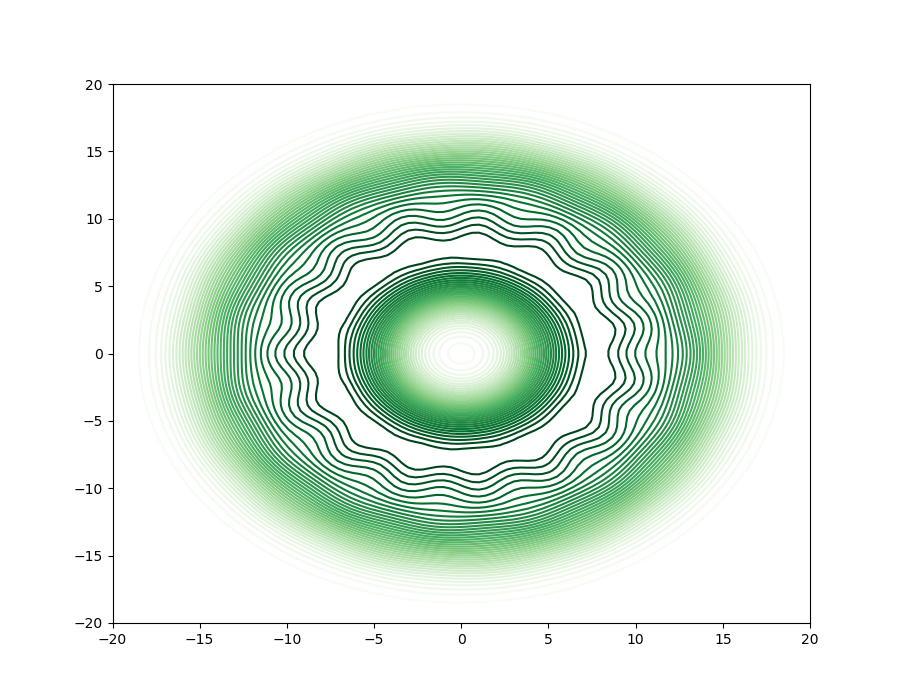

In [94]:
mix = None
for source in sources:
    mix *= source
plt.figure()
mix.plot(canvas, colors = "Greens", nlines=40)
plt.show()

<IPython.core.display.Javascript object>


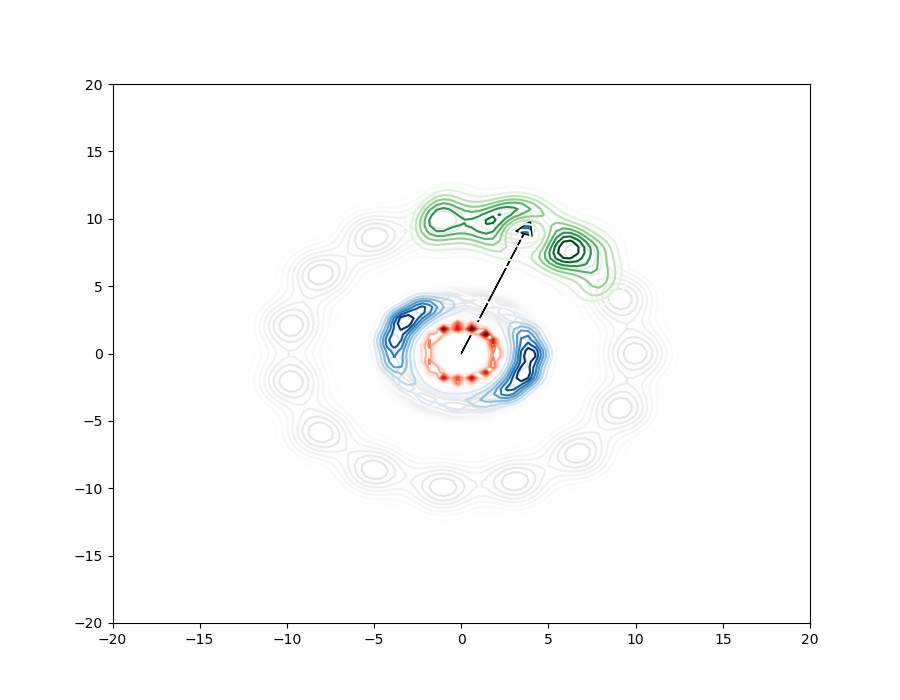

In [96]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

for (s, color) in zip(sources, colors):
    s.plot(canvas, plt.gca(), color, nlines=10)

def onclick(event):
    x = event.xdata+1j*event.ydata
    post = [s.post(mix,x) for s in sources]

    ax.clear()
    for (s, color) in zip(sources, colors):
        s.plot(canvas, ax, "Greys", nlines=10, alpha=0.1)
    for (s, color) in zip(post, colors):
        s.plot(canvas, ax, color, nlines=10)
    ax.arrow(0, 0, np.real(x), np.imag(x), head_width=1, head_length=1)
    plt.draw()
    
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [31]:
sources_LGM = [GMM(Bead(0,b,sigma)) for (b,sigma) in zip(bs,sigmas)]

for (s, color) in zip(sources_LGM, colors):
    s.plot(canvas, plt.gca(), color, nlines=10)
plt.show()

TypeError: __init__() takes 3 positional arguments but 4 were given

In [ ]:

plt.figure()
mix_LGM.plot(canvas, colors = "Greens", nlines=40)
plt.show()

# Audio source separation with magnitude priors: the BEADS model 

## Antoine Liutkus$^1$, Christian Rohlfing$^2$, Antoine Deleforge$^3$

$^1$ Zenith team, Inria, University of Montpellier, France<p>
$^2$ RWTH, Aachen University, Germany<p>
$^3$ Inria Rennes - Bretagne Atlantique, France<p>

<div class="inline-block">
    <img src="figures/zenith.jpg" style="height:3em; margin-top:5em">
</div>
<div class="inline-block">
    <img src ="figures/inria.png" style="height:3em">
</div>
<div class="inline-block">
    <img src="figures/rwth.svg" style="height:3em">
</div>
<div class="inline-block">
    <img src="figures/anr.png" style="height:3em">
</div>
</div>


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
iris = sns.load_dataset("iris")

# Subset the iris dataset by species
setosa = iris.query("species == 'setosa'")
virginica = iris.query("species == 'virginica'")

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(setosa.sepal_width, setosa.sepal_length,
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(virginica.sepal_width, virginica.sepal_length,
                 cmap="Blues", shade=True, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(2.5, 8.2, "virginica", size=16, color=blue)
ax.text(3.8, 4.5, "setosa", size=16, color=red)
plt.show()